# Classification on Motion Capture Dataset

## Metadata

In [29]:
name = "Aishwarya Prabhat"
gtUsername = "aprabhat7"
gtID = 903648486
dataset = "MoCap"

## Reading data

In [138]:
import pandas as pd
from sklearn import metrics
import pandas as pd
from sklearn import metrics
from sklearn.model_selection import learning_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import f1_score, make_scorer
import mlflow
import numpy as np
from matplotlib import pyplot as plt

In [31]:
df = pd.read_csv("data/Postures.csv")

In [32]:
df.head()

,Class,User,X0,Y0,Z0,X1,Y1,Z1,X2,Y2,...,Z8,X9,Y9,Z9,X10,Y10,Z10,X11,Y11,Z11
0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
1,1,0,54.263880,71.466776,-64.807709,76.895635,42.462500,-72.780545,36.621229,81.680557,...,?,?,?,?,?,?,?,?,?,?
2,1,0,56.527558,72.266609,-61.935252,39.135978,82.538530,-49.596509,79.223743,43.254091,...,?,?,?,?,?,?,?,?,?,?
3,1,0,55.849928,72.469064,-62.562788,37.988804,82.631347,-50.606259,78.451526,43.567403,...,?,?,?,?,?,?,?,?,?,?
4,1,0,55.329647,71.707275,-63.688956,36.561863,81.868749,-52.752784,86.320630,68.214645,...,?,?,?,?,?,?,?,?,?,?


In [33]:
df.describe()

,Class,User,X0,Y0,Z0,X1,Y1,Z1,X2,Y2,Z2
count,78096.000000,78096.000000,78096.000000,78096.000000,78096.000000,78096.000000,78096.000000,78096.000000,78096.000000,78096.000000,78096.000000
mean,2.983738,7.959127,50.345664,85.812051,-29.984712,49.595209,86.192647,-29.509202,48.612121,83.771315,-30.560515
std,1.421183,4.697810,32.696173,40.204363,34.361918,32.478238,40.453214,34.764398,33.605390,41.023543,35.120329
min,0.000000,0.000000,-108.552738,-98.233756,-126.770872,-111.685241,-96.142589,-166.006838,-106.886524,-100.789312,-129.595296
25%,2.000000,5.000000,29.295062,63.494432,-56.356438,28.755137,64.154529,-57.360107,25.170006,58.052385,-58.654059
50%,3.000000,9.000000,54.619964,86.526246,-30.864125,54.215514,87.542751,-30.184005,53.814580,86.458324,-32.352414
75%,4.000000,12.000000,72.488686,113.107355,-1.418803,71.762039,116.219398,-0.366692,71.561951,106.660827,-0.944786
max,5.000000,14.000000,190.017835,169.175464,113.345119,188.691997,170.209350,104.697852,188.760168,168.186466,104.590879


In [34]:
df.replace("?", 0, inplace=True)

## Splitting dataset into training and test sets

In [35]:
from sklearn.model_selection import train_test_split

X = df.drop(['Class','User'], axis=1)
y = df["Class"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1101)

## Training Models for hyperparameter tuning

### Decision trees with some form of pruning


In [156]:
from sklearn.tree import DecisionTreeClassifier

def decision_tree(X, y, max_depth=20, splitter="best"):
    clf = DecisionTreeClassifier(max_depth=max_depth, random_state=1101, splitter=splitter)
    clf.fit(X, y)
    return clf

In [155]:
import mlflow
import time
import pickle
import sys

mlflow.set_experiment("{}-decision-tree-pruning-2".format(dataset))
mlflow.sklearn.autolog()

for splitter in ["best", "random"]:
    for max_depth in [5,10,20,30,50,100]:
        with mlflow.start_run(run_name="Max depth: "+str(max_depth)) as run:
            start = time.time()
            clf = decision_tree(X_train, y_train, max_depth, splitter)
            end = time.time()
            y_pred = clf.predict(X_test)
            size = sys.getsizeof(pickle.dumps(clf))
            mlflow.log_param("max_depth", max_depth)
            mlflow.log_param("split_strategy", splitter)
            mlflow.log_metric("test_acc", metrics.accuracy_score(y_test, y_pred))
            mlflow.log_metric("training_time", end-start)
            mlflow.log_metric("model_size", size)

2021/09/27 06:53:15 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of sklearn. If you encounter errors during autologging, try upgrading / downgrading sklearn to a supported version, or try upgrading MLflow.


INFO: 'MoCap-decision-tree-pruning-2' does not exist. Creating a new experiment


#### Parallael coordinates plot obtained from Mlflow for decision tree pruning

![](images/dectree_pcp.png)

### Neural networks

In [9]:
from sklearn.neural_network import MLPClassifier

def neural_network(X, y, hidden_layer_sizes=(5,50)):
    clf = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes,
                        random_state=1101)
    clf.fit(X,y)
    return clf

In [107]:
import mlflow
import time
import pickle
import sys

mlflow.set_experiment("{}-neural-network-optimization".format(dataset))
mlflow.sklearn.autolog()

for x in [1,2,5]:
    for y in [1,5,10,50,100]:
        with mlflow.start_run(run_name="layers={}, nodes={}".format(x,y)) as run:
            start = time.time()
            clf = neural_network(X_train, y_train, (y,x))
            end = time.time()
            y_pred = clf.predict(X_test)
            size = sys.getsizeof(pickle.dumps(clf))
            
            mlflow.log_param("layers", x)
            mlflow.log_param("nodes", y)
            mlflow.log_metric("test_acc", metrics.accuracy_score(y_test, y_pred))
            mlflow.log_metric("training_time", end-start)
            mlflow.log_metric("model_size", size)

2021/09/25 08:17:50 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of sklearn. If you encounter errors during autologging, try upgrading / downgrading sklearn to a supported version, or try upgrading MLflow.
/Users/aish/opt/anaconda3/envs/cs7641/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/aish/opt/anaconda3/envs/cs7641/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
2021/09/25 08:18:24 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/aish/opt/anaconda3/envs/cs7641/lib/python3.9/site-packages/sklearn/utils

2021/09/25 08:20:19 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/aish/opt/anaconda3/envs/cs7641/lib/python3.9/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
/Users/aish/opt/anaconda3/envs/cs7641/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

2021/09/25 08:22:55 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/aish/opt/anaconda3/envs/cs7641/lib/python3.9/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
/Users/aish/opt/anaconda3/envs/cs7641/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

/Users/aish/opt/anaconda3/envs/cs7641/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
2021/09/25 08:26:46 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/aish/opt/anaconda3/envs/cs7641/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator."
2021/09/25 08:26:47 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/aish/opt/anaconda3/envs/cs7641/lib/python3.9/site-packages/mlflow/models/signature.py:129: UserWarning: Hin

![](images/nn_pcp.png)

### Boosting

In [15]:
from sklearn.ensemble import GradientBoostingClassifier

def boosted_dt(X,y, n_estimators, max_depth):
    clf = GradientBoostingClassifier(n_estimators=n_estimators, learning_rate=1.0,
                                     max_depth=max_depth, random_state=0)
    clf.fit(X,y)
    return clf

In [18]:
import mlflow
import time
import pickle
import sys
from sklearn import metrics

mlflow.set_experiment("{}-boosting-optimization".format(dataset))
mlflow.sklearn.autolog()

for n_estimators in [10,20,50,100]:
    for max_depth in [1,5,10,20]: #20 worked for decision trees so can set it as max
        with mlflow.start_run(run_name="n_estimators={}, max_depth={}".format(n_estimators,max_depth)) as run:
            start = time.time()
            clf = boosted_dt(X_train, y_train,n_estimators, max_depth)
            end = time.time()
            y_pred = clf.predict(X_test)
            size = sys.getsizeof(pickle.dumps(clf))
            
#             mlflow.log_param("n_estimators", x)
#             mlflow.log_param("max_depth", y)
            mlflow.log_metric("test_acc", metrics.accuracy_score(y_test, y_pred))
            mlflow.log_metric("training_time", end-start)
            mlflow.log_metric("model_size", size)

2021/09/25 09:19:16 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of sklearn. If you encounter errors during autologging, try upgrading / downgrading sklearn to a supported version, or try upgrading MLflow.
2021/09/25 09:19:27 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/aish/opt/anaconda3/envs/cs7641/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator."
2021/09/25 09:19:27 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/aish/opt/anaconda3/envs/cs7641/lib/python3.9/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

2021/09/25 09:27:54 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/aish/opt/anaconda3/envs/cs7641/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator."
2021/09/25 09:27:55 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/aish/opt/anaconda3/envs/cs7641/lib/python3.9/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic 

/Users/aish/opt/anaconda3/envs/cs7641/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
2021/09/25 09:45:43 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/aish/opt/anaconda3/envs/cs7641/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator."
2021/09/25 09:45:45 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/aish/opt/anaconda3/envs/cs7641/lib/python3.9/site-packages/mlflow/models/signature.py:129: UserWarning: Hin

![](images/boosting_pcp.png)

### SVM

In [17]:
from sklearn.svm import SVC

def svm(X,y, kernel="rbf", max_iter=10):
    clf = SVC(kernel=kernel, max_iter=max_iter)
    clf.fit(X,y)
    return clf

In [ ]:
import mlflow
import time
import pickle
import sys
from sklearn import metrics

mlflow.set_experiment("{}-svm-optimization".format(dataset))
mlflow.sklearn.autolog()

for kernel in ["linear", "poly", "rbf", "sigmoid"]:
    for max_iter in [2000, 5000, 10000]:
        with mlflow.start_run(run_name="kernel: {}, max_iter: {}".format(kernel, max_iter)) as run:
            start = time.time()
            clf = svm(X_train, y_train, kernel, max_iter)
            end = time.time()
            y_pred = clf.predict(X_test)
            size = sys.getsizeof(pickle.dumps(clf))

            mlflow.log_metric("test_acc", metrics.accuracy_score(y_test, y_pred))
            mlflow.log_metric("training_time", end-start)
            mlflow.log_metric("model_size", size)

2021/09/25 13:36:32 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of sklearn. If you encounter errors during autologging, try upgrading / downgrading sklearn to a supported version, or try upgrading MLflow.
/Users/aish/opt/anaconda3/envs/cs7641/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
2021/09/25 13:37:48 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/aish/opt/anaconda3/envs/cs7641/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator."
2021/09/25 13:38:49 WARNING mlflow.utils.autologging_utils: ML

/Users/aish/opt/anaconda3/envs/cs7641/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/aish/opt/anaconda3/envs/cs7641/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
2021/09/25 13:56:01 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/aish/opt/anaconda3/envs/cs7641/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatri

### KNN

In [10]:
from sklearn.neighbors import KNeighborsClassifier

def knn(X,y,n_neighbors):
    clf = KNeighborsClassifier(n_neighbors=n_neighbors)
    clf.fit(X,y)
    return clf

In [12]:
import mlflow
import time
import pickle
import sys
from sklearn import metrics

mlflow.set_experiment("{}-knn-optimization".format(dataset))
mlflow.sklearn.autolog()

fib = [1,5,8,13,35,56]
for n_neighbors in fib:
    with mlflow.start_run(run_name="N: "+str(n_neighbors)) as run:
        clf = knn(X_train, y_train, n_neighbors)
        start = time.time()
        y_pred = clf.predict(X_test)
        end = time.time()
        size = sys.getsizeof(pickle.dumps(clf))

        mlflow.log_metric("test_acc", metrics.accuracy_score(y_test, y_pred))
        mlflow.log_metric("inference_time", end-start)
        mlflow.log_metric("model_size", size)

## Comparing models

In [144]:
from sklearn.model_selection import learning_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import ShuffleSplit


def get_learning_curve(estimator, X, y):
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=1101)
    train_sizes, train_scores, test_scores, fit_times, score_times = learning_curve(estimator, 
                                                                      X, y, 
                                                                      cv=cv, #stratified k-fold
                                                                      n_jobs=4,
                                                                      shuffle=True,
                                                                      return_times=True)
    return train_sizes, train_scores, test_scores, fit_times, score_times

In [145]:
class ExperimentModel():
    def __init__(self, name, estimator):
        self.name = name
        self.estimator = estimator
        self.train_sizes = None
        self.train_scores = None
        self.test_scores  = None
        self.fit_times = None
        self.score_times = None
        
estimators = [
    ("Decision Tree", DecisionTreeClassifier(max_depth=20, random_state=1101)),
    ("Neural Network", MLPClassifier(hidden_layer_sizes=(50,5), random_state=1101)),
    ("Boosting", GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=10, random_state=1101)),
    ("SVM", SVC(kernel="rbf", max_iter=1000)),
    ("KNN", KNeighborsClassifier(n_neighbors=1))
]

models = []

In [146]:
from tqdm.notebook import tqdm

for estimator in tqdm(estimators):
    model = ExperimentModel(estimator[0], estimator[1])
    model.train_sizes, model.train_scores, model.test_scores, model.fit_times, model.score_times = get_learning_curve(estimator[1], X, y)
    models.append(model)
    print("Done with {}".format(estimator[0]))
    

  0%|          | 0/5 [00:00<?, ?it/s]

Done with Decision Tree


/Users/aish/opt/anaconda3/envs/cs7641/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/aish/opt/anaconda3/envs/cs7641/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/aish/opt/anaconda3/envs/cs7641/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/aish/opt/anaconda3/envs/cs7641/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged ye

Done with Neural Network
Done with Boosting


/Users/aish/opt/anaconda3/envs/cs7641/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/aish/opt/anaconda3/envs/cs7641/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/aish/opt/anaconda3/envs/cs7641/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/aish/opt/anaconda3/envs/cs7641/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/aish/opt/anaconda3/envs/c

Done with SVM


/Users/aish/opt/anaconda3/envs/cs7641/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/aish/opt/anaconda3/envs/cs7641/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/aish/opt/anaconda3/envs/cs7641/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/aish/opt/anaconda3/envs/cs7641/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/aish/opt/anaconda3/envs/cs7641/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier wa

/Users/aish/opt/anaconda3/envs/cs7641/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/aish/opt/anaconda3/envs/cs7641/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/aish/opt/anaconda3/envs/cs7641/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/aish/opt/anaconda3/envs/cs7641/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/aish/opt/anaconda3/envs/cs7641/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier wa

Done with KNN


In [147]:
import numpy as np
from matplotlib import pyplot as plt

def generate_plots(models):
    fig, axes = plt.subplots(3, 2, figsize=(15, 20))

#     plt.rcParams.update({'font.size': 10})
    for model in models:
        axes[0, 0].plot(model.train_sizes, np.mean(model.train_scores, axis=1), label=model.name)
        axes[0, 1].plot(model.train_sizes, np.mean(model.test_scores, axis=1), label=model.name)
        axes[1, 0].plot(model.train_sizes, np.mean(model.fit_times, axis=1), label=model.name)
        axes[1, 1].plot(model.train_sizes, np.mean(model.score_times, axis=1), label=model.name)
        axes[2, 0].plot(model.train_sizes, np.mean(model.train_scores, axis=1)-np.mean(model.test_scores, axis=1), label=model.name)
        
    #training performance vs no. samples
    axes[0, 0].grid()
    axes[0, 0].legend(loc="best")
    axes[0, 0].set_xlabel("No. of training examples")
    axes[0, 0].set_ylabel("Mean training score")
    axes[0, 0].set_title("Training performance vs Dataset size")

    #test performance vs no. samples
    axes[0, 1].grid()
    axes[0, 1].legend(loc="best")
    axes[0, 1].set_xlabel("No. of training examples")
    axes[0, 1].set_ylabel("Mean Val score")
    axes[0, 1].set_title("Val performance vs Dataset size")

    #training time vs no. samples
    axes[1, 0].grid()
    axes[1, 0].legend(loc="best")
    axes[1, 0].set_xlabel("No. of training examples")
    axes[1, 0].set_ylabel("Mean training time (fit_time)")
    axes[1, 0].set_title("Training scalability")
    
    #inference time vs no. samples
    axes[1, 1].grid()
    axes[1, 1].legend(loc="best")
    axes[1, 1].set_xlabel("No. of training examples")
    axes[1, 1].set_ylabel("Mean inference time (score_time)")
    axes[1, 1].set_title("Inference scalability")
    
    #ioverfitting vs no. samples
    axes[2, 0].grid()
    axes[2, 0].legend(loc="best")
    axes[2, 0].set_xlabel("No. of training examples")
    axes[2, 0].set_ylabel("Overfitting (train_score-Val_score)")
    axes[2, 0].set_title("Overfitting vs Dataset size")

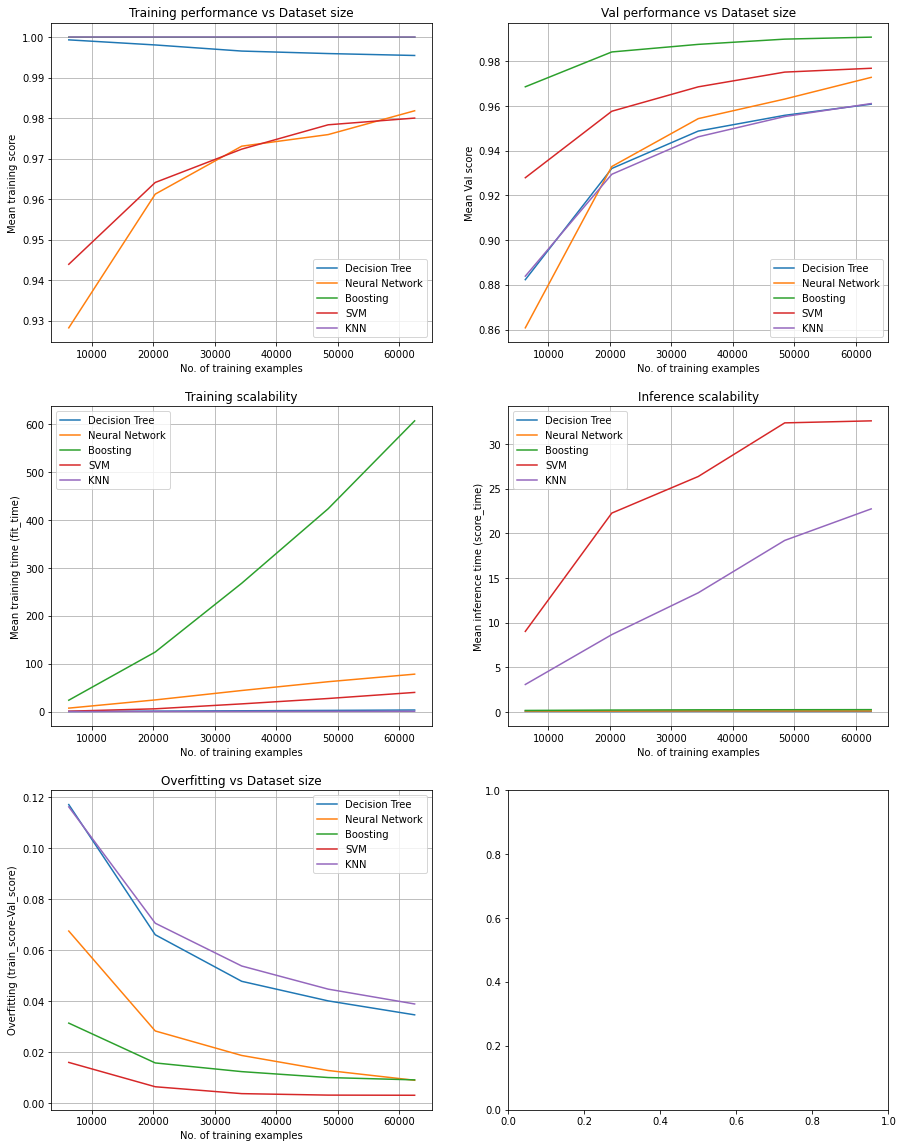

In [148]:
generate_plots(models)